## 日本画分類コンペ　画像分類　pytorch 転移学習

# Settings

In [1]:
!nvidia-smi

Sat Aug  6 10:44:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:01:00.0  On |                  Off |
| 30%   45C    P8    24W / 230W |    808MiB / 24222MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip uninstall albumentations -y

In [3]:
#!pip install timm -q
#!pip install albumentations -q

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import time
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, models, transforms
from sklearn.model_selection import GroupKFold, StratifiedKFold

from datetime import datetime
from tqdm.autonotebook import tqdm as tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensor
from sklearn.metrics import roc_auc_score

import timm
import cv2

In [6]:
class CFG:
    def __init__(self):
        
        self.debug=False
        self.num_workers=0
        #self.model_name='efficientnet_b0'
        self.model_name= 'efficientnet_b4' #'mobilenetv3_large_100_miil_in21k' #'efficientnet_b4' #resnet34d
        self.size= 380 #256 #224
        self.scheduler='CosineAnnealingLR'  
        self.epochs= 20
        self.T_max=4
        self.lr=1e-3
        self.min_lr=1e-4
        self.batch_size = 16 #32 #4 #16
        self.weight_decay=5e-5
        self.dropout=0.5 #0.5
        self.seed= 2021 #42
        self.n_fold = 5
        self.alpha = 1.0
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.version = "102"

CONFIG = CFG()

In [7]:
def seed_everything(seed:int==42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG.seed)

# Data Load

In [8]:
## Google Driveに保存されているディレクトリ指定
#INPUT_DIR = "/content/drive/MyDrive/probspace/religion/data/raw/"
#BASE_DIR = "/content/drive/MyDrive/probspace/religion/data/interim/"
BASE_DIR = "../output/"

#MODEL_DIR = f'{BASE_DIR}for_topic/'
#OUTPUT_DIR = f'{BASE_DIR}for_topic/'

MODEL_DIR = f'../models/'
OUTPUT_DIR = f'{BASE_DIR}'

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [9]:
#file_list = sorted(glob.glob(os.path.join(INPUT_DIR, '*')))

#for i, file in enumerate(file_list):
    
#    print(f'{i} | {file}')

In [10]:
#train_label = np.load("/content/drive/MyDrive/probspace/religion/data/raw/christ-train-labels.npz")['arr_0']
#train_image = np.load("/content/drive/MyDrive/probspace/religion/data/raw/christ-train-imgs.npz")['arr_0']
#test_image = np.load("/content/drive/MyDrive/probspace/religion/data/raw/christ-test-imgs.npz")['arr_0']

In [11]:
#train_image = np.load("../input/train_data.npz")['arr_0']
#test_image = np.load("../input/test_data.npz")['arr_0']
#train_image.shape, test_image.shape

In [12]:
train_label = np.load("../input/train_data.npz")['arr_1']
train_label.shape

(6446,)

In [13]:
train_label

array([1, 1, 0, ..., 0, 1, 1], dtype=int32)

In [14]:
train_label_df = pd.DataFrame(train_label)

In [15]:
train_label_df.value_counts()

0    3013
1    2201
2     619
3     613
dtype: int64

In [16]:
classes=len(train_label_df[0].unique())
classes

4

In [17]:
i=10
string=f'../input/train/{i:04d}.jpg'
string

'../input/train/0010.jpg'

In [18]:
'''
import cv2
for i in range(6446):
    img=train_image[i]
    #img = img.transpose([2,0,1])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'../input/train/{i}.jpg', img)
    #break
'''

"\nimport cv2\nfor i in range(6446):\n    img=train_image[i]\n    #img = img.transpose([2,0,1])\n    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)\n    cv2.imwrite(f'../input/train/{i}.jpg', img)\n    #break\n"

In [19]:
BASE = "../input/"
annotation_path = BASE 
image_path = BASE + "train"

In [20]:
image_paths = glob.glob(os.path.join(annotation_path+ "train" , '*.jpg'))
image_paths.sort()
train_id=image_paths #image_paths[:100]
train_id

['../input/train/0000.jpg',
 '../input/train/0001.jpg',
 '../input/train/0002.jpg',
 '../input/train/0003.jpg',
 '../input/train/0004.jpg',
 '../input/train/0005.jpg',
 '../input/train/0006.jpg',
 '../input/train/0007.jpg',
 '../input/train/0008.jpg',
 '../input/train/0009.jpg',
 '../input/train/0010.jpg',
 '../input/train/0011.jpg',
 '../input/train/0012.jpg',
 '../input/train/0013.jpg',
 '../input/train/0014.jpg',
 '../input/train/0015.jpg',
 '../input/train/0016.jpg',
 '../input/train/0017.jpg',
 '../input/train/0018.jpg',
 '../input/train/0019.jpg',
 '../input/train/0020.jpg',
 '../input/train/0021.jpg',
 '../input/train/0022.jpg',
 '../input/train/0023.jpg',
 '../input/train/0024.jpg',
 '../input/train/0025.jpg',
 '../input/train/0026.jpg',
 '../input/train/0027.jpg',
 '../input/train/0028.jpg',
 '../input/train/0029.jpg',
 '../input/train/0030.jpg',
 '../input/train/0031.jpg',
 '../input/train/0032.jpg',
 '../input/train/0033.jpg',
 '../input/train/0034.jpg',
 '../input/train/003

In [21]:
image_paths = glob.glob(os.path.join(annotation_path + "test", '*.jpg'))
image_paths.sort()
test_id=image_paths #image_paths[:100]
test_id

['../input/test/0000.jpg',
 '../input/test/0001.jpg',
 '../input/test/0002.jpg',
 '../input/test/0003.jpg',
 '../input/test/0004.jpg',
 '../input/test/0005.jpg',
 '../input/test/0006.jpg',
 '../input/test/0007.jpg',
 '../input/test/0008.jpg',
 '../input/test/0009.jpg',
 '../input/test/0010.jpg',
 '../input/test/0011.jpg',
 '../input/test/0012.jpg',
 '../input/test/0013.jpg',
 '../input/test/0014.jpg',
 '../input/test/0015.jpg',
 '../input/test/0016.jpg',
 '../input/test/0017.jpg',
 '../input/test/0018.jpg',
 '../input/test/0019.jpg',
 '../input/test/0020.jpg',
 '../input/test/0021.jpg',
 '../input/test/0022.jpg',
 '../input/test/0023.jpg',
 '../input/test/0024.jpg',
 '../input/test/0025.jpg',
 '../input/test/0026.jpg',
 '../input/test/0027.jpg',
 '../input/test/0028.jpg',
 '../input/test/0029.jpg',
 '../input/test/0030.jpg',
 '../input/test/0031.jpg',
 '../input/test/0032.jpg',
 '../input/test/0033.jpg',
 '../input/test/0034.jpg',
 '../input/test/0035.jpg',
 '../input/test/0036.jpg',
 

In [22]:
#train_image = np.array(train_image)
#train_label = np.array(train_label)
#train_image.shape,train_label.shape

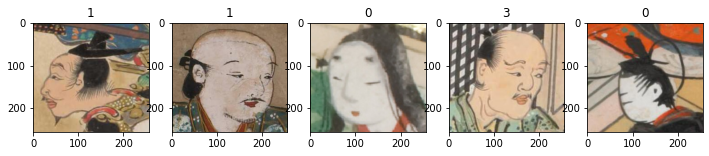

In [23]:
plt.figure(figsize=(12, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img=cv2.imread(train_id[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, aspect='auto')
    #plt.imshow(train_image[i], aspect='auto')
    plt.title(train_label[i])
plt.show()

In [24]:
classes=np.unique(train_label).size
print(f'クラス数: {np.unique(train_label).size}')

クラス数: 4


### pseudo labeling 

In [25]:
file1 = pd.read_csv("../output/001_topic_baseline_pred_000-tta.csv")
file1

,id,y,pred_0,pred_1,pred_2,pred_3
0,1,1,2.152781e-05,0.499252,3.520143e-07,2.550681e-04
1,2,0,2.944788e-01,0.247496,9.719448e-05,4.254586e-04
2,3,0,4.999979e-01,0.000001,8.032005e-07,1.607333e-07
3,4,2,1.338031e-02,0.002722,4.321338e-01,6.011259e-02
4,5,1,1.712825e-01,0.356057,6.049560e-05,4.978077e-03
...,...,...,...,...,...,...
1995,1996,1,8.591535e-06,0.499780,4.049825e-07,6.112483e-04
1996,1997,1,3.067364e-03,0.491648,1.388720e-04,3.232522e-03
1997,1998,2,3.101877e-06,0.000029,4.999890e-01,2.771245e-06
1998,1999,1,3.740897e-04,0.488186,1.070467e-05,2.231048e-02


In [26]:
test_pred_max =file1[{'pred_0','pred_1','pred_2','pred_3'}].max(axis=1)
file1['max']=test_pred_max
file1

,id,y,pred_0,pred_1,pred_2,pred_3,max
0,1,1,2.152781e-05,0.499252,3.520143e-07,2.550681e-04,0.499252
1,2,0,2.944788e-01,0.247496,9.719448e-05,4.254586e-04,0.294479
2,3,0,4.999979e-01,0.000001,8.032005e-07,1.607333e-07,0.499998
3,4,2,1.338031e-02,0.002722,4.321338e-01,6.011259e-02,0.432134
4,5,1,1.712825e-01,0.356057,6.049560e-05,4.978077e-03,0.356057
...,...,...,...,...,...,...,...
1995,1996,1,8.591535e-06,0.499780,4.049825e-07,6.112483e-04,0.499780
1996,1997,1,3.067364e-03,0.491648,1.388720e-04,3.232522e-03,0.491648
1997,1998,2,3.101877e-06,0.000029,4.999890e-01,2.771245e-06,0.499989
1998,1999,1,3.740897e-04,0.488186,1.070467e-05,2.231048e-02,0.488186


In [27]:
file1['y'].value_counts()

0    984
1    667
3    179
2    170
Name: y, dtype: int64

<AxesSubplot:>

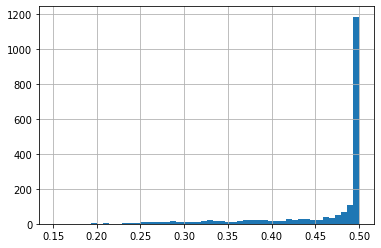

In [28]:
file1['max'].hist(bins=50)

In [29]:
for index, data in file1.iterrows():
    if data['max'] > 0.49:
        if data['y']== 3 or data['y'] == 2:
            #print(data)
            train_label = np.append(train_label, int(data['y']))
            train_id = np.append(train_id, test_id[index]) 
    #break

In [30]:
train_id.shape,train_label.shape

((6592,), (6592,))

# Training

## DataSet

In [31]:
class TrainDataset:
    
    def __init__(self, path, target, transform=None):
        
        self.path = path
        #self.image = image
        self.target = target
        self.transform = transform
        
    def __len__(self):
        #return len(self.image)
        return len(self.path)
    
    def __getitem__(self, item):
        
        #image = self.image[item]
        image = cv2.imread(self.path[item])
        image = cv2.resize(image, (CONFIG.size, CONFIG.size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        target = self.target[item]
        
        #print("item:",item, self.path[item], target)

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed['image']
            
        else:
            image = image[np.newaxis, :, :]
        
        #処理
        
        
        return {
            'image' : torch.tensor(image, dtype=torch.float),
            'target' : torch.tensor(target, dtype=torch.float).long(),
        }

In [32]:
class TestDataset:
    
    def __init__(self, path, transform=None):
        
        self.path = path
        #self.image = image
        self.transform = transform
        
    def __len__(self):
        #return len(self.image)
        return len(self.path)
    
    def __getitem__(self, item):
        
        #image = self.image[item]
        image = cv2.imread(self.path[item])
        image = cv2.resize(image, (CONFIG.size, CONFIG.size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed['image']
            
        else:
            image = image[np.newaxis, :, :]
        
        #処理
        
        return {
            'image' : torch.tensor(image, dtype=torch.float),
        }

In [33]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CONFIG.size, CONFIG.size),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.05),
            A.VerticalFlip(p=0.2),#0.5
            A.HorizontalFlip(p=0.5),#0.5
            A.Rotate(p=0.2), #0.3
            A.ToSepia(p=0.3),
            A.Normalize(),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return A.Compose([
            A.Resize(CONFIG.size, CONFIG.size),
            A.Normalize(),
            ToTensorV2(),
        ])
    

## Model

In [34]:
class Model(nn.Module):
    
    def __init__(self, CONFIG, pretrained=False):
        super().__init__()
        self.CONFIG = CONFIG
        self.backbone = timm.create_model(self.CONFIG.model_name, 
                                          pretrained=pretrained,
                                          in_chans=3)
        
        self.n_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(self.n_features, classes)
        
        
    def forward(self, x):
        output = self.backbone(x)
        output = F.log_softmax(output, dim = 1)
        return output

## Helper Function

In [35]:
def train_func(model, optimizer, scheduler, loss_fn, dataloader, device):
    
    model.train()
    final_loss = 0
    
    for step, data in enumerate(dataloader):
        
        s_t = time.time()
        optimizer.zero_grad()
        
        image = data['image'].to(device)
        label = data['target'].to(device)
        batch_size = label.size(0)
        
        preds = model(image)

        loss = loss_fn(preds, label)

        e_t = time.time()
        e_t = e_t - s_t

        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss

In [36]:
def valid_func(model, loss_fn, dataloader, device):
    
    model.eval()

    final_loss = 0
    valid_preds = []

    for step, data in enumerate(dataloader):
        
        s_t = time.time()
        image = data['image'].to(device)
        label = data['target'].to(device)

        preds = model(image)
            
        loss = loss_fn(preds, label)
        e_t = time.time()
        e_t = e_t - s_t

        valid_preds.append(preds.sigmoid().detach().cpu().numpy())
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

In [37]:
def test_func(model, dataloader, device):
    
    model.eval()
        
    final_loss = 0
    test_preds = []

    for step, data in tqdm(enumerate(dataloader)):
        
        s_t = time.time()
        image = data['image'].to(device)

        preds = model(image)
            
        e_t = time.time()
        e_t = e_t - s_t
        
        test_preds.append(preds.sigmoid().detach().cpu().numpy())
                
    test_preds = np.concatenate(test_preds)
    
    return test_preds

In [38]:
from sklearn.metrics import accuracy_score

#CV = StratifiedKFold(n_splits=CONFIG.n_fold, random_state=CONFIG.seed)
CV = StratifiedKFold(n_splits=CONFIG.n_fold)

#oof = np.zeros((train_image.shape[0], classes))
#pred = np.zeros((test_image.shape[0], classes))
oof = np.zeros((len(train_id), classes))
pred = np.zeros((len(test_id), classes))

device = CONFIG.device

for fold, (tr, te) in enumerate(CV.split(train_id, train_label)):

    print(f'==================== Fold {fold+1} ======================')

    #tr_image = train_image[tr]
    #va_image = train_image[te]
    tr_image = np.array(train_id)[tr]
    va_image = np.array(train_id)[te]
    
    tr_target = train_label[tr]
    va_target = train_label[te]
    #print(tr_target)

    train_dataset = TrainDataset(tr_image, tr_target, 
                                    get_transforms(data='train'))
    valid_dataset = TrainDataset(va_image, va_target,
                                    get_transforms(data='valid'))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=CONFIG.batch_size,
                                                num_workers=CONFIG.num_workers,
                                                pin_memory=True,
                                                shuffle=True)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                batch_size=CONFIG.batch_size,
                                                num_workers=CONFIG.num_workers,
                                                pin_memory=True,
                                                shuffle=False)
    
    print("model")
    model = Model(CONFIG, pretrained=True)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=CONFIG.lr,
                                  weight_decay=CONFIG.weight_decay)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max=CONFIG.T_max,
                                                         eta_min=CONFIG.min_lr,
                                                         last_epoch=-1)

    loss_fn = nn.CrossEntropyLoss()

    best_score = 0
    print("epoch")
    for epoch in range(CONFIG.epochs):

        start_time = time.time()
        train_loss = train_func(model, optimizer, scheduler,
                                loss_fn, train_loader, device)
        valid_loss, valid_preds = valid_func(model, loss_fn,
                                                valid_loader, device)

        score = accuracy_score(va_target, np.argmax(valid_preds, axis=1))

        end_time = time.time()
        print(f"FOLD: {fold+1} | EPOCH:{epoch+1:02d} | train_loss:{train_loss:.6f} | valid_loss:{valid_loss:.6f} | valid_score:{score:.4f} | time:{end_time-start_time:.1f}s ")


        if score > best_score:
            best_score = score
            oof[te] = valid_preds
                
            MODEL_PATH = f"{MODEL_DIR}topic_{CONFIG.version}_baseline_{CONFIG.model_name}_fold{fold+1}.pth"
            torch.save(model.state_dict(), MODEL_PATH)

        else:
            continue

    print("after epoch")
    del train_dataset, valid_dataset, train_loader, valid_loader, valid_preds
    _ = gc.collect()


    ## Predict
    model.load_state_dict(torch.load(MODEL_PATH))
    test_dataset = TestDataset(test_id,
                                 get_transforms(data='valid'))
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=CONFIG.batch_size,
                                              num_workers=CONFIG.num_workers,
                                              pin_memory=True,
                                              shuffle=False)
    test_preds = test_func(model, test_loader, device)
    pred += test_preds/CONFIG.n_fold

    del test_dataset, test_loader, model
    #break
print("finish")


==================== Fold 1 ======================
model
epoch
FOLD: 1 | EPOCH:01 | train_loss:0.634265 | valid_loss:0.421473 | valid_score:0.8423 | time:125.6s 
FOLD: 1 | EPOCH:02 | train_loss:0.352727 | valid_loss:0.408514 | valid_score:0.8453 | time:125.4s 
FOLD: 1 | EPOCH:03 | train_loss:0.255008 | valid_loss:0.353457 | valid_score:0.8605 | time:123.3s 
FOLD: 1 | EPOCH:04 | train_loss:0.184729 | valid_loss:0.428886 | valid_score:0.8681 | time:123.3s 
FOLD: 1 | EPOCH:05 | train_loss:0.151245 | valid_loss:0.399235 | valid_score:0.8764 | time:120.7s 
FOLD: 1 | EPOCH:06 | train_loss:0.136168 | valid_loss:0.455273 | valid_score:0.8696 | time:120.8s 
FOLD: 1 | EPOCH:07 | train_loss:0.103378 | valid_loss:0.452255 | valid_score:0.8757 | time:121.2s 
FOLD: 1 | EPOCH:08 | train_loss:0.104932 | valid_loss:0.528113 | valid_score:0.8537 | time:120.6s 
FOLD: 1 | EPOCH:09 | train_loss:0.082857 | valid_loss:0.538776 | valid_score:0.8734 | time:120.1s 
FOLD: 1 | EPOCH:10 | train_loss:0.084752 | val

0it [00:00, ?it/s]

==================== Fold 2 ======================
model
epoch
FOLD: 2 | EPOCH:01 | train_loss:0.646374 | valid_loss:0.408483 | valid_score:0.8469 | time:120.9s 
FOLD: 2 | EPOCH:02 | train_loss:0.381711 | valid_loss:0.409438 | valid_score:0.8491 | time:119.9s 
FOLD: 2 | EPOCH:03 | train_loss:0.276294 | valid_loss:0.421687 | valid_score:0.8666 | time:120.9s 
FOLD: 2 | EPOCH:04 | train_loss:0.217511 | valid_loss:0.354831 | valid_score:0.8764 | time:121.5s 
FOLD: 2 | EPOCH:05 | train_loss:0.168154 | valid_loss:0.391898 | valid_score:0.8848 | time:121.2s 
FOLD: 2 | EPOCH:06 | train_loss:0.147467 | valid_loss:0.414643 | valid_score:0.8916 | time:120.0s 
FOLD: 2 | EPOCH:07 | train_loss:0.129984 | valid_loss:0.376768 | valid_score:0.8863 | time:120.1s 
FOLD: 2 | EPOCH:08 | train_loss:0.097106 | valid_loss:0.452838 | valid_score:0.8810 | time:120.6s 
FOLD: 2 | EPOCH:09 | train_loss:0.098050 | valid_loss:0.505476 | valid_score:0.8764 | time:120.2s 
FOLD: 2 | EPOCH:10 | train_loss:0.098621 | val

0it [00:00, ?it/s]

==================== Fold 3 ======================
model
epoch
FOLD: 3 | EPOCH:01 | train_loss:0.643668 | valid_loss:0.410128 | valid_score:0.8445 | time:121.4s 
FOLD: 3 | EPOCH:02 | train_loss:0.384482 | valid_loss:0.380975 | valid_score:0.8543 | time:120.3s 
FOLD: 3 | EPOCH:03 | train_loss:0.266696 | valid_loss:0.353183 | valid_score:0.8680 | time:120.9s 
FOLD: 3 | EPOCH:04 | train_loss:0.201217 | valid_loss:0.395254 | valid_score:0.8801 | time:120.4s 
FOLD: 3 | EPOCH:05 | train_loss:0.165047 | valid_loss:0.359191 | valid_score:0.8839 | time:120.3s 
FOLD: 3 | EPOCH:06 | train_loss:0.136381 | valid_loss:0.380367 | valid_score:0.8839 | time:120.0s 
FOLD: 3 | EPOCH:07 | train_loss:0.126640 | valid_loss:0.390888 | valid_score:0.8877 | time:120.5s 
FOLD: 3 | EPOCH:08 | train_loss:0.099181 | valid_loss:0.448960 | valid_score:0.8877 | time:120.4s 
FOLD: 3 | EPOCH:09 | train_loss:0.102633 | valid_loss:0.403884 | valid_score:0.8869 | time:123.2s 
FOLD: 3 | EPOCH:10 | train_loss:0.081871 | val

0it [00:00, ?it/s]

==================== Fold 4 ======================
model
epoch
FOLD: 4 | EPOCH:01 | train_loss:0.655506 | valid_loss:0.392730 | valid_score:0.8460 | time:121.4s 
FOLD: 4 | EPOCH:02 | train_loss:0.382179 | valid_loss:0.379163 | valid_score:0.8513 | time:120.0s 
FOLD: 4 | EPOCH:03 | train_loss:0.260995 | valid_loss:0.349129 | valid_score:0.8741 | time:120.6s 
FOLD: 4 | EPOCH:04 | train_loss:0.196399 | valid_loss:0.362723 | valid_score:0.8741 | time:120.1s 
FOLD: 4 | EPOCH:05 | train_loss:0.154506 | valid_loss:0.383893 | valid_score:0.8672 | time:120.5s 
FOLD: 4 | EPOCH:06 | train_loss:0.141525 | valid_loss:0.384662 | valid_score:0.8786 | time:120.0s 
FOLD: 4 | EPOCH:07 | train_loss:0.103555 | valid_loss:0.401060 | valid_score:0.8816 | time:120.7s 
FOLD: 4 | EPOCH:08 | train_loss:0.118559 | valid_loss:0.340652 | valid_score:0.8907 | time:120.1s 
FOLD: 4 | EPOCH:09 | train_loss:0.079633 | valid_loss:0.456152 | valid_score:0.8741 | time:119.9s 
FOLD: 4 | EPOCH:10 | train_loss:0.082189 | val

0it [00:00, ?it/s]

==================== Fold 5 ======================
model
epoch
FOLD: 5 | EPOCH:01 | train_loss:0.649797 | valid_loss:0.380456 | valid_score:0.8566 | time:120.2s 
FOLD: 5 | EPOCH:02 | train_loss:0.387486 | valid_loss:0.331718 | valid_score:0.8649 | time:120.4s 
FOLD: 5 | EPOCH:03 | train_loss:0.263222 | valid_loss:0.389820 | valid_score:0.8642 | time:120.6s 
FOLD: 5 | EPOCH:04 | train_loss:0.193267 | valid_loss:0.308113 | valid_score:0.8877 | time:121.1s 
FOLD: 5 | EPOCH:05 | train_loss:0.152983 | valid_loss:0.378963 | valid_score:0.8892 | time:121.4s 
FOLD: 5 | EPOCH:06 | train_loss:0.129433 | valid_loss:0.319993 | valid_score:0.9067 | time:124.7s 
FOLD: 5 | EPOCH:07 | train_loss:0.111652 | valid_loss:0.321488 | valid_score:0.8998 | time:123.6s 
FOLD: 5 | EPOCH:08 | train_loss:0.100046 | valid_loss:0.372327 | valid_score:0.9052 | time:122.7s 
FOLD: 5 | EPOCH:09 | train_loss:0.098228 | valid_loss:0.431066 | valid_score:0.8824 | time:123.3s 
FOLD: 5 | EPOCH:10 | train_loss:0.082948 | val

0it [00:00, ?it/s]

finish


In [39]:
pred.shape

(2000, 4)

In [40]:
oof_df = pd.DataFrame(columns=['target', 'pred'])
oof_df['target'] = train_label
oof_df['pred'] = np.argmax(oof, axis=1).astype(int)

for i in range(classes):
    oof_df[f'pred_{i}'] = oof[:, i]

oof_score = accuracy_score(oof_df['target'], oof_df['pred'])
oof_df.to_csv(os.path.join(OUTPUT_DIR, f"{CONFIG.version}_topic_baseline_{oof_score:.5f}.csv"), index=False)
print(f'OOF_Score: {oof_score:.6f}')
display(oof_df.head())
#0.893422

OOF_Score: 0.898362


,target,pred,pred_0,pred_1,pred_2,pred_3
0,1,1,9.507495e-08,4.999996e-01,3.946383e-10,1.205464e-06
1,1,1,4.133235e-10,4.999995e-01,8.030179e-10,1.893163e-06
2,0,0,4.999978e-01,2.668099e-06,1.227330e-09,6.155922e-06
3,3,3,8.070553e-03,2.081870e-01,2.584428e-05,4.216021e-01
4,0,0,4.999998e-01,1.117380e-07,8.025111e-10,5.464670e-07


## Inference

In [41]:
#inference
pred = np.zeros((len(test_id), classes))

test_dataset = TestDataset(test_id,
                                 get_transforms(data='valid'))
test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=CONFIG.batch_size,
                                              num_workers=CONFIG.num_workers,
                                              pin_memory=True,
                                              shuffle=False)

for fold in tqdm(range(CONFIG.n_fold)):

    print(f'==================== Fold {fold+1} ======================')
    
    #model準備
    model = Model(CONFIG, pretrained=True)
    model.to(CONFIG.device)
    
    MODEL_PATH = f"{MODEL_DIR}topic_{CONFIG.version}_baseline_{CONFIG.model_name}_fold{fold+1}.pth"
    
    ## Predict
    model.load_state_dict(torch.load(MODEL_PATH))
    
    test_preds = test_func(model, test_loader, device)
    pred += test_preds/CONFIG.n_fold

pred_df = pd.DataFrame(columns=['id', 'y'])
pred_df['id'] = [i+1 for i in range(len(test_id))]
pred_df['y'] = np.argmax(pred, axis=1).astype('int')

for i in range(classes):
    pred_df[f'pred_{i}'] = pred[:, i]

## Submit
pred_df[['id', 'y']].to_csv(os.path.join(OUTPUT_DIR, f"{CONFIG.version}_topic_baseline_submit_{oof_score:.5f}-2.csv"), index=False)

## for Ensemble
pred_df.to_csv(os.path.join(OUTPUT_DIR, f"{CONFIG.version}_topic_baseline_pred_{oof_score:.5f}-2.csv"), index=False)

del test_dataset, test_loader, model

print("finish")

  0%|          | 0/5 [00:00<?, ?it/s]

==================== Fold 1 ======================


0it [00:00, ?it/s]

==================== Fold 2 ======================


0it [00:00, ?it/s]

==================== Fold 3 ======================


0it [00:00, ?it/s]

==================== Fold 4 ======================


0it [00:00, ?it/s]

==================== Fold 5 ======================


0it [00:00, ?it/s]

finish


In [42]:
display(pred_df.head())

,id,y,pred_0,pred_1,pred_2,pred_3
0,1,1,0.000006,0.499715,6.221666e-07,0.001125
1,2,0,0.432487,0.100870,1.024613e-06,0.000080
2,3,0,0.499995,0.000012,9.270053e-07,0.000007
3,4,2,0.004319,0.000725,4.905541e-01,0.025898
4,5,1,0.009123,0.494677,3.901045e-05,0.010738


In [43]:
oof_df['target'].value_counts()

0    3013
1    2201
2     747
3     631
Name: target, dtype: int64

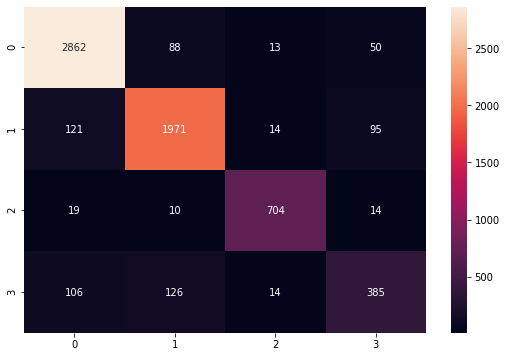

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#N = [60,42,132,42,42,60,48,30,30,66,30,42,30]

cm = confusion_matrix(oof_df['target'], np.argmax(oof, axis=1).astype(int))

plt.figure(figsize=(9, 6))
sns.heatmap(cm, annot=True, fmt='d')
#plt.xlim(12, 0)
#plt.ylim(0, 12)
plt.show()

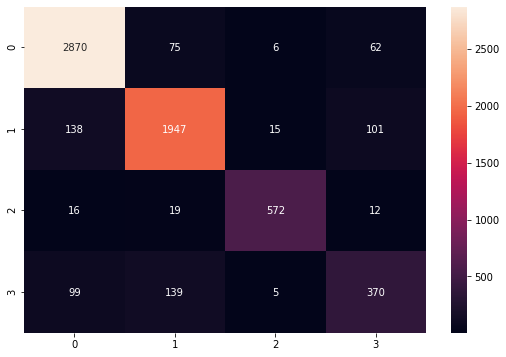

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#N = [60,42,132,42,42,60,48,30,30,66,30,42,30]

cm = confusion_matrix(oof_df['target'], np.argmax(oof, axis=1).astype(int))

plt.figure(figsize=(9, 6))
sns.heatmap(cm, annot=True, fmt='d')
#plt.xlim(12, 0)
#plt.ylim(0, 12)
plt.show()

In [38]:
import ttach as tta

tta_transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 180]),
        tta.Scale(scales=[0.5, 1, 1.5]),
        tta.Resize([0.5, 1, 1.5]), ##
        #tta.Multiply(factors=[0.9, 1, 1.1]),
        #tta.FiveCrops(50,50),
    ]
)

In [39]:
batch_size=2
#inference
pred = np.zeros((len(test_id), classes))

test_dataset = TestDataset(test_id,
                                 get_transforms(data='valid'))
test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              num_workers=CONFIG.num_workers,
                                              pin_memory=True,
                                              shuffle=False)

for fold in tqdm(range(CONFIG.n_fold)):

    print(f'==================== Fold {fold+1} ======================')
    
    #model準備
    model = Model(CONFIG, pretrained=True)
    
    model.to(CONFIG.device)
    
    MODEL_PATH = f"{MODEL_DIR}topic_{CONFIG.version}_baseline_{CONFIG.model_name}_fold{fold+1}.pth"
    model.load_state_dict(torch.load(MODEL_PATH))
    
    #tta_model = tta.ClassificationTTAWrapper(base_model, tta.aliases.five_crop_transform()) #tta2
    tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.flip_transform()) #tta1
    
    ## Predict
    test_preds = test_func(tta_model, test_loader, CONFIG.device)
    pred += test_preds/CONFIG.n_fold

pred_df = pd.DataFrame(columns=['id', 'y'])
pred_df['id'] = [i+1 for i in range(len(test_id))]
pred_df['y'] = np.argmax(pred, axis=1).astype('int')

for i in range(classes):
    pred_df[f'pred_{i}'] = pred[:, i]


  0%|          | 0/5 [00:00<?, ?it/s]

==================== Fold 1 ======================


0it [00:00, ?it/s]

==================== Fold 2 ======================


0it [00:00, ?it/s]

==================== Fold 3 ======================


0it [00:00, ?it/s]

==================== Fold 4 ======================


0it [00:00, ?it/s]

==================== Fold 5 ======================


0it [00:00, ?it/s]

In [40]:
## Submit
pred_df[['id', 'y']].to_csv(os.path.join(OUTPUT_DIR, f"{CONFIG.version}_topic_baseline_submit_000-tta1.csv"), index=False)

## for Ensemble
pred_df.to_csv(os.path.join(OUTPUT_DIR, f"{CONFIG.version}_topic_baseline_pred_000-tta1.csv"), index=False)

del test_dataset, test_loader, model

print("finish")

finish
